### Spectral Clustering

In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from silx.io.dictdump import h5todict
from sklearn.cluster import SpectralClustering

In [2]:
from scipy import constants
eV_to_J = constants.eV

Inputs

In [3]:
nb_states = 6115
kin_file = "/home/zanardi/Workspace/AirDatabase/HDF5/QCT/Orig/O3_UMN.hdf5"
lev_file = "/home/zanardi/Codes/TC/HyperNet/database/levels/O3_UMN/O2.csv"

In [4]:
nb_b = 3
nb_qb = 1
# nb_b = 6
# nb_qb = 2
nb = nb_b + nb_qb

Databases

In [5]:
kinetics = h5todict(kin_file)

In [6]:
k = kinetics["T_10000_10000"]["Rates"]["Inel"]
k = np.tril(k, k=-1)

In [7]:
levels = pd.read_csv(lev_file)
e = (levels["E"] - np.amin(levels["E"])).values * eV_to_J
e_d = 5.113 * eV_to_J
e_v = levels["EVib"].values
e_r = levels["ERot"].values
e_v -= e_v.min()
e_r -= e_r.min()
J = levels["jqn"].values

In [8]:
iv = np.where(levels["jqn"] == 0)[0]
e_d = np.amax(e_v[iv]) #* eV_to_J
e_d

5.1130347854413

In [28]:
e = e - e_d

Bound and quasi-bound states

In [9]:
i = np.where(e > e_d)[0][0]
i_b = np.arange(i)
i_qb = np.arange(i,nb_states)

In [10]:
def get_probmat(
  mapping
):
  mapping = (mapping - np.amin(mapping)).astype(int)
  nb_levs, nb_bins = len(mapping), np.amax(mapping)+1
  data = np.ones(nb_levs)
  indices = (np.arange(nb_levs), mapping)
  shape = (nb_levs, nb_bins)
  return sp.sparse.coo_matrix((data, indices), shape).toarray()

> Energy-based clustering

In [11]:
def energy_bin(e, e_d, nb_b, nb_qb, eps=1e-6):
  # Min/max energies
  e_min, e_max = np.amin(e), np.amax(e)
  # Energy intervals
  inter_b = np.linspace(e_min, e_d, nb_b+1)
  if (nb_qb > 0):
    inter_qb = np.linspace(e_d, e_max, nb_qb+1)[1:]
  else:
    inter_qb = np.array([])
  intervals = np.concatenate([inter_b, inter_qb])
  intervals[-1] *= 1.0+eps
  # Define mapping
  mapping = (e.reshape(-1,1) >= intervals.reshape(1,-1))
  mapping = np.sum(mapping, axis=1)
  return mapping

In [12]:
map_en = energy_bin(e, e_d, nb_b, nb_qb, eps=1e-6)
map_en_b = map_en[:i]
map_en_qb = map_en[i:]

> Spectral clustering

In [13]:
def get_s(e, k, fk=1.0, fe=1.0):
  de = np.abs(e.reshape(-1,1) - e.reshape(1,-1))
  kmin = k[k>0].min() * 1e-5
  kk = k + k.T + kmin
  s = de**fe / kk**fk
  return np.exp(-s)

def spectral_bin(e, k, i, nb=6, fk=1.0, fe=1.0):
  ei, ki = e[i], k[i][:,i]
  clust = SpectralClustering(n_clusters=nb, affinity='precomputed', random_state=0)
  mapping = clust.fit_predict(get_s(ei, ki, fk, fe))
  mapping += 1-np.amin(mapping)
  return mapping

In [14]:
if nb_qb > 1:
  fk, fe = 1.45, 0.94
else:
  fk, fe = 1.45, 1.0
map_sp_b = spectral_bin(e, k, i_b, nb_b, fk, fe)
map_sp_qb = spectral_bin(e, k, i_qb, nb_qb, fk=1.45, fe=1.0)
map_sp = np.concatenate([map_sp_b, map_sp_qb+nb_b])

Plot clustering

In [42]:
def plot_clust_2d(map, title, filename=None):
  plt.figure()
  for c in range(map.max()):
    i = (map == c+1)
    plt.scatter(J[i], e[i], s=2)
  plt.xlabel('$J$')
  plt.ylabel('$\epsilon_i$ [eV]')
  plt.title(title)
  plt.tight_layout()
  if filename:
    plt.savefig(filename)
  plt.show()

def plot_clust_1d(map, title):
  plt.figure()
  for c in range(map.max()):
    i = (map == c+1)
    plt.scatter(e[i]/eV_to_J, np.ones_like(e[i])*(c+1), s=2)
  plt.xlabel('$\epsilon_i$ [eV]')
  plt.ylabel('Cluster')
  plt.title(title)
  plt.show()

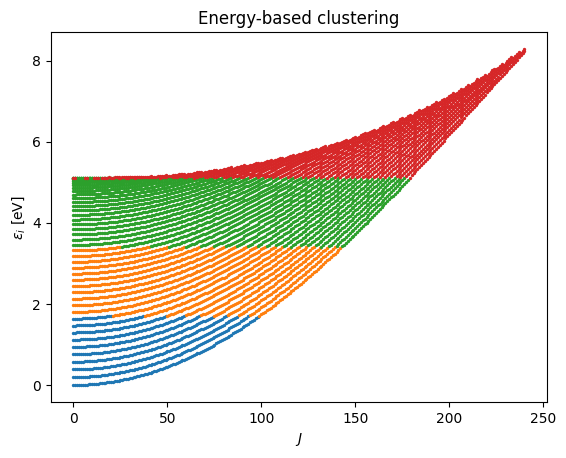

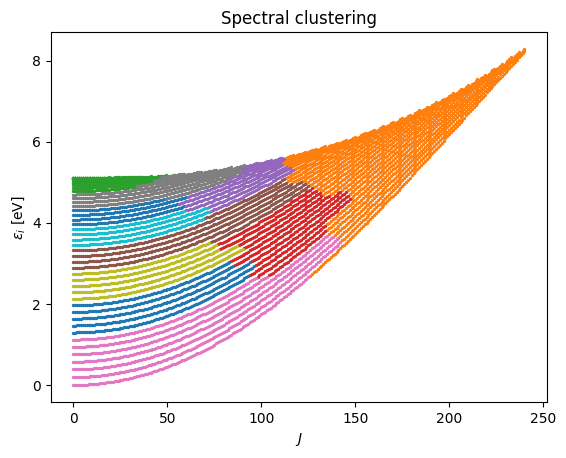

In [17]:
plot_clust_2d(map_en, title="Energy-based clustering")
plot_clust_2d(map_sp, title="Spectral clustering")

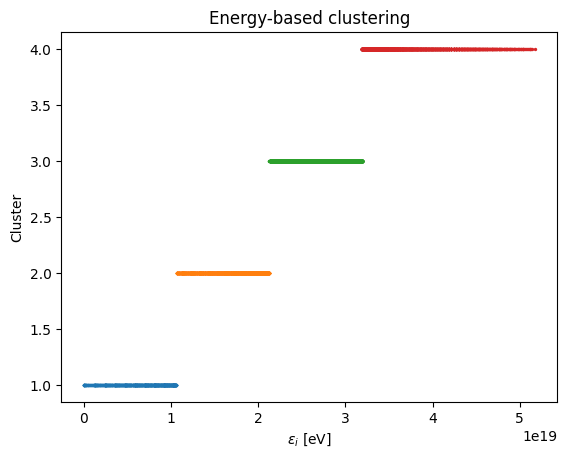

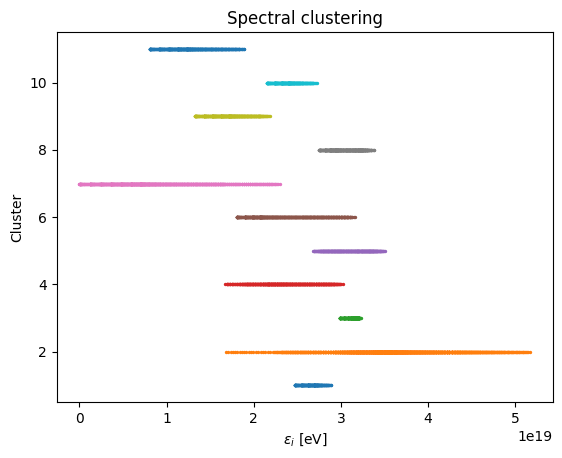

In [18]:
plot_clust_1d(map_en, title="Energy-based clustering")
plot_clust_1d(map_sp, title="Spectral clustering")

Save clustering

In [19]:
path_to_saving = f"./../testcases/RVE{nb}/"
os.makedirs(path_to_saving, exist_ok=True)
np.savetxt(
  path_to_saving + "/mapping.csv",
  np.vstack([np.arange(nb_states), map_en]).T,
  fmt='%i',
  delimiter=',',
  header='Idx,Group'
)

In [20]:
path_to_saving = f"./../rom_cg/ADA{nb}/"
os.makedirs(path_to_saving, exist_ok=True)
np.savetxt(
  path_to_saving + "/mapping.csv",
  np.vstack([np.arange(nb_states), map_sp]).T,
  fmt='%i',
  delimiter=',',
  header='Idx,Group'
)